##Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

##Tópico estudado das notas *CS231n Convolutional Neural Networks for Visual Recognition*:

*   Convolutional Neural Networks: Architectures, Convolution / Pooling Layers

##1. Arquitetura de *redes neurais convolucionais* (*CNNs*)

Redes neurais convolucionais, assim como as convencionais, possuem pesos, vieses, funções de ativação (como a sigmoide) e funções de custo. Porém, uma suposição que é feita para CNNs é a de que a entrada é sempre uma imagem, o que nos permite trabalhar com boas propriedades desse tipo de entrada. É importante pontuar que as NNs convencionais não têm escalabilidade com imagens, o contrário do que acontece com as CNNs.

As CNNs usam a propriedade de que imagens podem ser representadas tridimensionalmente (com largura, altura e número de canais, como o padrão RGB, com $3$ canais) e, assim, suas camadas (chamadas de volumes) possuem $3$ dimensões também: largura, altura e profundidade. Uma CNN, assim como uma NN, é uma sequência de camadas que transformam um volume de ativações em outra. Há três camadas principais: camada convolucional, camada de pooling e, a mesma das NNs, camada totalmente conectada. Um exemplo de arquitetura de CNN é [ENTRADA - CONV - ATIV - POOL - CONECT], explicadas a seguir:
* ENTRADA [$32\times32\times3$] é a camada dos valores da imagem para cada pixel. Usaremos um modelo de imagem com largura $32$, altura $32$ e com $3$ canais de cor RGB como exemplo;
* CONV computa a saída dos neurônios que estão conectados a regiões da entrada, cada um fazendo o produto interno entre seus pesos e uma região pequena de valores do volume de entrada. A saída poderia ser um volume [$32\times32\times12$], se usarmos $12$ filtros (explicados em breve);
* ATIV aplica uma função de ativação para cada valor do volume, como a sigmoide ou ReLU. O tamanho do volume de saída seria o mesmo;
* POOL diminui o volume pelas dimensões espaciais (largura e volume). O volume de saída poderia ficar [$16\times16\times12$];
* CONECT computa (nesse contexto) as pontuações de classe (como as pontuações de dígitos no dataset MNIST), resultando num volume de saída de tamanho [$1\times1\times10$]. Cada neurônio dessa camada fica conectado a todos as outras unidades do volume anterior.

Algumas camadas não possuem parâmetros (pesos e vieses), como as camadas ATIV e POOL (que simplesmente aplicam uma função fixa de ativação e *downsampling*, respectivamente), mas o restante possui, como as camadas CONV e CONECT, que permitem um treinamento com gradiente descendente.

##2. Descrição das camadas convolucional e de pooling das CNNs

###2.1. Camada convolucional

A camada convolucional possui um conjunto de filtros que podem ser aprendidos, e cada filtro é pequeno em espaço (como [$5\times5\times3$]), mas cobre toda a profundidade do volume de entrada. Durante a etapa de feedforward, é realizada a convolução ou "deslizamento" de cada filtro pela largura e altura do volume de entrada, e essa operação consiste na realização do produto interno entre cada região de entrada em "deslizamento" e os valores do filtro. Isso produz uma matriz bidimensional com as saídas do filtro a cada posição. A CNN consegue aprender os filtros que ativam quando há um aspecto visual na imagem, como uma borda, agrupamento ou padrão de valores de entrada. Cada filtro produz uma matriz separada. O empilhamento dessas matrizes pela dimensão de profundidade gera o volume de saída.

Uma outra característica importante dessa camada é a conectividade local. Entradas com tamanhos grandes atrapalham na eficiência de NNs, como acontece com imagens. As CNNs utilizam um hiperparâmetro chamado de *campo receptivo*, que é o tamanho dos filtros, responsável pela escalabilidade dessas redes com tamanhos de entrada grandes. Nesse contexto, a profundidade dos filtros é sempre igual à profundidade das entradas. No exemplo citado, cada filtro ficará conectada a uma região de tamanho [$5\times5\times3$] do volume de entrada, o que resulta em um total de $5\times5\times3=75$ pesos e um viés. Além do tamanho do filtro, há também os hiperparâmetros *profundidade*, *stride* e *zero-padding*. O hiperparâmetro profundidade essencialmente controla o número de filtros que serão utilizados; uma *coluna de profundidade* ou fibra corresponde a um conjunto de neurônios (ou todos os filtros) que estão conectados à mesma região pequena da entrada. O stride controla o tamanho dos "pulos" que damos com os filtros conforme realizamos as convoluções; se o stride for $1$, movemos os filtros um pixel de cada vez, e se o stride for $2$, pulamos um pixel de modo a mover os filtros dois pixels de cada vez (o que gera uma saída de tamanho espacial menor), por exemplo. O zero-padding consiste na inserção de $0$ na borda da imagem, e o número desse hiperparâmetro controla o tamanho  dessa borda especial de valores iguais a $0$.

O tamanho espacial do volume de saída nesse caso pode ser obtido através da fórmula
\begin{align*}
\frac{W-F+2P}{S}+1,
\end{align*}
em que $W$ corresponde ao tamanho do volume de entrada, $F$ ao campo receptivo, $S$ ao stride e $P$ o tamanho do zero-padding. O valor de resultado da fórmula deve ser um número inteiro para o correto funcionamento da CNN. Nesse contexto, o zero-padding é especialmente útil pois conseguimos controlar o tamanho do volume de saída de forma mais flexível (normalmente, $F$ e $S$ não podem ser grandes demais), prevenindo o problema citado.

Um outro aspecto da camada que garante uma melhor eficiência é o compartilhamento de parâmetros: uma forma de reduzir o número de pesos é supor que, para a mesma "fatia" de profundidade (ou seja, para um mesmo filtro), é bom utilizar o mesmo conjunto de parâmetros, já que uma aquisição de característica da imagem (uma convolução com um filtro) em uma região é útil de computar também para outras regiões. Na etapa de backpropagation, o gradiente é computado para todo neurônio, mas os gradientes serão usados para atualizar um só conjunto de pesos por fatia. Como é possível realizar a convolução (daí o nome da camada) dos pesos dos neurônios com o volume de entrada por esse esquema, chamamos os conjuntos de pesos de filtros ou *kernels*. Às vezes é relevante abandonar essa suposição, como quando as entradas são imagens de rostos, com características mais específicas para cada região (como formatos de nariz e boca no centro das imagens ou cabelo perto das bordas), e nesse caso chamamos a camada de *camada localmente conectada*.

###2.2. Camada de pooling

Camadas de pooling servem para diminuir o tamanho espacial do volume de entrada e são normalmente usadas entre camadas convolucionais sucessivas. Isso promove uma maior eficiência de computação e um maior controle de overfitting. Para fazer isso, a camada comumente aplica uma função de máximo em cada fatia de profundidade do volume de entrada independemente. A operação de máximo num exemplo com tamanho de filtro $F=2$ e stride $S=2$ (também são hiperparâmetros aqui) seleciona o máximo valor de uma região $2\times2$ a cada $2$ pixels. O volume de saída consiste em uma largura igual a $\frac{W-F}{S}+1$, altura igual a $\frac{H-F}{S}+1$ e profundidade igual a $D$, em que $W$ é a largura da entrada, $H$ a altura e $D$ a profundidade. Na etapa de backpropagation, o gradiente da operação de máximo corresponde à entrada com o maior valor na etapa de feedforward. Por esse motivo, na etapa de feedforward é comum registrar o índice da ativação máxima para que o algoritmo de backpropagation fique mais eficiente para CNNs.

Uma implementação de CNN em PyTorch para o dataset CIFAR10 com 10 classes segue abaixo.

In [2]:
# Extraído do próprio tutorial do PyTorch (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=1)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=1)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:04<00:00, 42.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


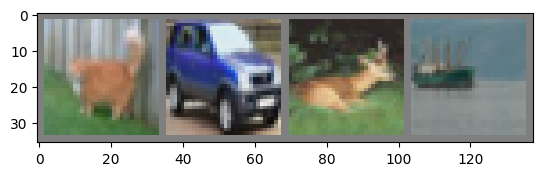

cat   car   deer  ship 


In [3]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [12]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # essa e as próximas 2 camadas são totalmente conectadas
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # [CONV - ATIV - POOL]
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)

In [13]:
for epoch in range(8):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] perda: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Treinamento Concluído')

[1,  2000] perda: 2.302
[1,  4000] perda: 2.301
[1,  6000] perda: 2.299
[1,  8000] perda: 2.294
[1, 10000] perda: 2.282
[1, 12000] perda: 2.237
[2,  2000] perda: 2.114
[2,  4000] perda: 2.055
[2,  6000] perda: 2.007
[2,  8000] perda: 1.967
[2, 10000] perda: 1.945
[2, 12000] perda: 1.899
[3,  2000] perda: 1.850
[3,  4000] perda: 1.805
[3,  6000] perda: 1.766
[3,  8000] perda: 1.704
[3, 10000] perda: 1.683
[3, 12000] perda: 1.632
[4,  2000] perda: 1.621
[4,  4000] perda: 1.592
[4,  6000] perda: 1.561
[4,  8000] perda: 1.536
[4, 10000] perda: 1.536
[4, 12000] perda: 1.518
[5,  2000] perda: 1.498
[5,  4000] perda: 1.471
[5,  6000] perda: 1.467
[5,  8000] perda: 1.444
[5, 10000] perda: 1.437
[5, 12000] perda: 1.429
[6,  2000] perda: 1.400
[6,  4000] perda: 1.391
[6,  6000] perda: 1.376
[6,  8000] perda: 1.398
[6, 10000] perda: 1.370
[6, 12000] perda: 1.342
[7,  2000] perda: 1.339
[7,  4000] perda: 1.320
[7,  6000] perda: 1.339
[7,  8000] perda: 1.306
[7, 10000] perda: 1.300
[7, 12000] perda

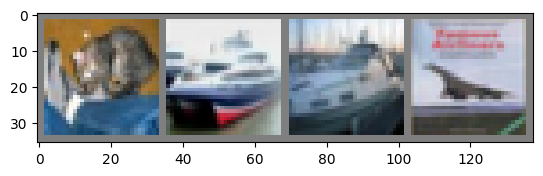

GroundTruth:  cat   ship  ship  plane
Predito:  cat   ship  car   plane


In [14]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predito: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

In [17]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Precisão da rede nas 10000 imagens de teste: {100 * correct // total}%')

Precisão da rede nas 10000 imagens de teste: 56%


In [16]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Precisão para a classe: {classname:5s} é {accuracy:.1f}%')

Precisão para a classe: plane é 58.4%
Precisão para a classe: car   é 73.1%
Precisão para a classe: bird  é 38.0%
Precisão para a classe: cat   é 41.2%
Precisão para a classe: deer  é 41.6%
Precisão para a classe: dog   é 53.2%
Precisão para a classe: frog  é 65.1%
Precisão para a classe: horse é 61.0%
Precisão para a classe: ship  é 70.2%
Precisão para a classe: truck é 60.2%
